In [517]:
import pandas as pd
import numpy as np

import copy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import math

In [518]:
def createdf(filename): #створення фрейму
    df = pd.read_csv(filename)
    
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.isnull().any()
    return(df)

In [519]:
filename = "csv//int20h-ds-test-dataset.csv"

In [520]:
df = createdf(filename)

In [521]:
df["event_created_date"] = pd.to_datetime(df["event_created_date"])

In [522]:
print(str(df.shape[0]) +" rows x " + str(df.shape[1]) + " columns")
df.head()

23357 rows x 8 columns


,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
0,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Success,"{""Make"":""Dodge"",""Model"":""Caravan"",""Color"":""Whi...",2022-01-16 17:03:04,android,samsung,SM-N975U
1,c95c777785faec8dd910d019d7278ebe,CA,Add Vehicle Break,{},2022-01-16 17:07:47,android,samsung,SM-N975U
2,f344be2d9a042b7444f3cc5279e38ef1,FL,Calculator View,{},2022-01-16 17:16:25,android,samsung,SM-G973U1
3,c95c777785faec8dd910d019d7278ebe,CA,Add Payment Method Success,"{""Payment Method"":""Credit"",""Tokenized Pay"":""""}",2022-01-16 17:24:22,android,samsung,SM-N975U
4,e331ed81422d8fba55520a43a872e701,IL,Sign Up Success,"{""Method"":""Apple""}",2022-01-16 17:34:51,ios,Apple,"iPhone12,1"


In [523]:
#drop users that have not added, renewed or canceled Subscription Premium - they haven't canceled it because they had no sub

def remove_excess_data(df):
    target_values = ['Subscription Premium Cancel', 'Subscription Premium', 'Subscription Premium Renew', "Order"]
    sign_up_value = "Sign Up Success"
    user_list = df["userid"].unique()
    for i in user_list:
        df_temp = df[df["userid"]==i]
        if target_values[0] in df_temp.values or target_values[1] in df_temp.values:
            continue
        elif target_values[2] in df_temp.values or  target_values[3] in df_temp.values:
            continue
        elif (sign_up_value not in df_temp.values):
            continue
        df = df.drop(df_temp.index)
    return df

In [524]:
df = remove_excess_data(df)

In [525]:
df = df.sort_values(["userid", "event_created_date"], ascending=[True, True]).reset_index(drop = True)

In [526]:
#Замінюємо невідомі значення пристроїв з яких виконувалися дії 
#користувачів для яких відомий пристрій за іншими діями на ці пристрої
def fill_in_NaNs(df):
    
    for i in range(len(df)):
        if df.loc[i, "event_platform"] == "outofband":
            df_temp = df[df["userid"] == df.iloc[i]["userid"]]
            for index, row in df_temp.iterrows():
                if row["event_platform"] != "outofband":
                    df.loc[i, "event_platform"] = row.at["event_platform"]
                    df.loc[i, "device_manufacture"] = row.at["device_manufacture"]
                    df.loc[i, "device_model"] = row.at["device_model"]
                    break
                    
    df_temp = df[df["user_state"].apply(lambda x: isinstance(x, float))]
    df = df.drop(df_temp.index).reset_index(drop = True)
    #    for index, row in df_temp.iterrows():
    #        if row["user_state"] != np.nan:
    #            temp_state = row["user_state"]
    #            break
    #        df = df.drop(df_temp.index)
    #    df[df["userid"] == user]["user_state"] = temp_state
    
    #states = (df["user_state"].unique()) #nan crutch
    #states = states[~numpy.isnan(states)]
    #for i in range(len(df)):
    #    if isinstance(df.loc[i, "user_state"], float):
    #        df_temp = df[df["userid"] == df.iloc[i]["userid"]]
    #        for index, row in df_temp.iterrows():
    #            if not isinstance(row["user_state"], float):
    #                df.loc[i, "user_state"] = row.at["user_state"]
    #                break
    #            i = i-len(df_temp)
    #            df = df.drop(df_temp.index).reset_index(drop = True)
                
                
    
    return df


In [527]:
df = fill_in_NaNs(df).reset_index(drop = True)
df_canceled = df[df["event_name"] == 'Subscription Premium Cancel']
#print(str(df_canceled.shape[0]) +" rows x " + str(df_canceled.shape[1]) + " columns")
canceled_list = df_canceled["userid"].unique()
df_canceled.head()

,userid,user_state,event_name,event_attributes,event_created_date,event_platform,device_manufacture,device_model
75,03e0c91e1163e8b80e74e586a3e666d6,MD,Subscription Premium Cancel,{},2022-02-24 19:45:02,ios,Apple,"iPhone12,1"
171,051a5f8bce75a601be987980a09d4187,VA,Subscription Premium Cancel,{},2022-04-06 10:12:37,ios,Apple,"iPhone14,2"
180,05630c0e889fe7371fc74d7ae01f491f,FL,Subscription Premium Cancel,{},2022-03-19 18:16:37,ios,Apple,"iPhone13,2"
195,060153cf7a5844d9aed735d408b35f97,TX,Subscription Premium Cancel,{},2022-02-11 15:06:11,ios,Apple,"iPhone14,2"
215,078ae59f1ae79df514e846e5e51eca8b,CA,Subscription Premium Cancel,{},2022-04-09 12:43:36,ios,Apple,"iPhone12,1"


In [528]:
def event_occured_per_user(row):
    if row['userid'] in event_list:
        return 1
    else:
        return 0

In [529]:
def event_occured(row):
    if row["event_name"] == event:
        return 1
    else:
        return 0

In [530]:
event = 'Subscription Premium Cancel'
df_temp = df[df["event_name"] == event]
event_list = df_temp["userid"].unique()
df[event] = df.apply(event_occured_per_user, axis=1)

In [531]:
df.to_csv("csv//sorted_filled_test.csv")

In [532]:
df = createdf("csv//sorted_filled_test.csv")

In [533]:
#виводимо з значення дати значення місяця, квартал, день тижня та час події в хвилинах
def event_created_date_transform(df):
    date = pd.DataFrame({"time" : []})
    date["time"] = pd.to_datetime(df["event_created_date"])
    date["month"] = date["time"].dt.month
    date["quarter"] = date["time"].dt.quarter
    date["day_week"] = date["time"].dt.dayofweek
    #date["time"] = (date["time"].dt.minute.to_numpy(dtype=np.int32) + date["time"].dt.hour.to_numpy(dtype=np.int32)*60)/(60*24) #minute of the day
    date["time"] = date["time"].dt.hour.to_numpy(dtype=np.int32) #hour of the day
    return date

In [534]:
date = event_created_date_transform(df)

In [535]:
date.to_csv("csv//extracted_date_data.csv")

In [536]:
df_canceled = df[df["event_name"] == 'Subscription Premium Cancel']
canceled_list = df_canceled["userid"].unique()

In [537]:
df_time = copy.deepcopy(df)

In [538]:
event = 'Subscription Premium Cancel'
df_time[event] = df_time.apply(event_occured, axis=1)

In [539]:
df_time = df_time.drop(['userid', 'event_name', 'event_attributes',
                        'event_created_date', "user_state", "event_platform","device_manufacture", "device_model"], axis=1)

In [540]:
df_time = pd.concat([df_time, date], axis=1)

In [541]:
df_time.to_csv("csv//event_and_date_data.csv")

In [542]:
df_event_occured = copy.deepcopy(df)
events = df["event_name"].unique()

In [543]:
for e in events:
    event = e
    df_temp = df_event_occured[df_event_occured["event_name"] == event]
    event_list = df_temp["userid"].unique()
    df_event_occured[event] = df_event_occured.apply(event_occured_per_user, axis=1)

In [544]:
df_event_occured = df_event_occured.drop(['event_name', 'event_attributes', 'event_created_date',
                                          "user_state", "event_platform","device_manufacture", "device_model"], axis=1)

In [545]:
df_event_occured = df_event_occured.drop_duplicates(subset = ["userid"])

In [546]:

#fig, ax = plt.subplots(figsize=(15,15))    
#dataplot = sns.heatmap(df_event_occured.drop(["userid"], axis = 1).corr(), cmap="RdYlBu", annot=True, ax = ax)
#plt.show()

In [547]:
df_event_occured.to_csv("csv//event_occured_per_user.csv")

In [548]:
df2 = copy.deepcopy(df)

In [549]:
label_encoder = LabelEncoder()
df_static_data = copy.deepcopy(df2.drop(['userid', 'event_name', 'event_attributes', 'event_created_date'], axis=1))


In [550]:
categories = ["user_state", "event_platform","device_manufacture", "device_model"]
for category in categories:
    #print(df_static_data[category].unique())
    df_static_data[category]=label_encoder.fit_transform(df_static_data[category])
    #print(df_static_data[category].unique())


In [551]:
#dataplot = sns.heatmap(df_static_data.corr(), cmap="RdYlBu", annot=True)
#plt.show()

In [552]:
df_static_data.to_csv("csv//static_data.csv")

In [553]:
df_feature_by_state = copy.deepcopy(df)
events = df["event_name"].unique()

def event_occured_per_state(row):
    if row['user_state'] in event_list:
        return 1
    else:
        return 0

for e in events:
    event = e
    if (event == 'Subscription Premium Cancel'):
        continue
    df_temp = df_feature_by_state[df_feature_by_state["event_name"] == event]
    event_list = df_temp["user_state"].unique()
    df_feature_by_state[event] = df_feature_by_state.apply(event_occured_per_state, axis=1)

In [554]:
df_feature_by_state = df_feature_by_state.drop(['event_attributes', 'event_created_date', 
                                                "event_platform","device_manufacture", "device_model"], axis=1)

In [555]:
#df_feature_by_state = df_feature_by_state.drop_duplicates(subset = ["user_state"])

In [556]:
#df_feature_by_state.groupby(["user_state", 'Subscription Premium Cancel'])["user_state"].count().unstack(fill_value=0).stack()

In [557]:
count = df_feature_by_state.groupby(["user_state", 'Subscription Premium Cancel'])["user_state"].count().unstack(fill_value=0).stack()

In [558]:
len(count)

72

In [559]:
cancel_percentage = [float(count[2*i + 1])/(count[2*i] + count[2*i + 1]) for i in range(int(len(count)/2))]

In [560]:
df_feature_per_state = copy.deepcopy(df_feature_by_state)

df_feature_per_state = df_feature_per_state.drop(['Subscription Premium Cancel', 'Subscription Premium', 'Subscription Premium Renew', 'Sign Up Success'], axis=1)
df_feature_per_state = df_feature_per_state.drop_duplicates(subset = ["user_state"])

df_feature_per_state = df_feature_per_state.drop(['userid', 'event_name'], axis = 1).sort_values(["user_state"]).reset_index(drop = True)
#df_feature_per_state

In [561]:
df_feature_per_state["cancel_percentage"] = cancel_percentage

In [562]:
#df_feature_per_state

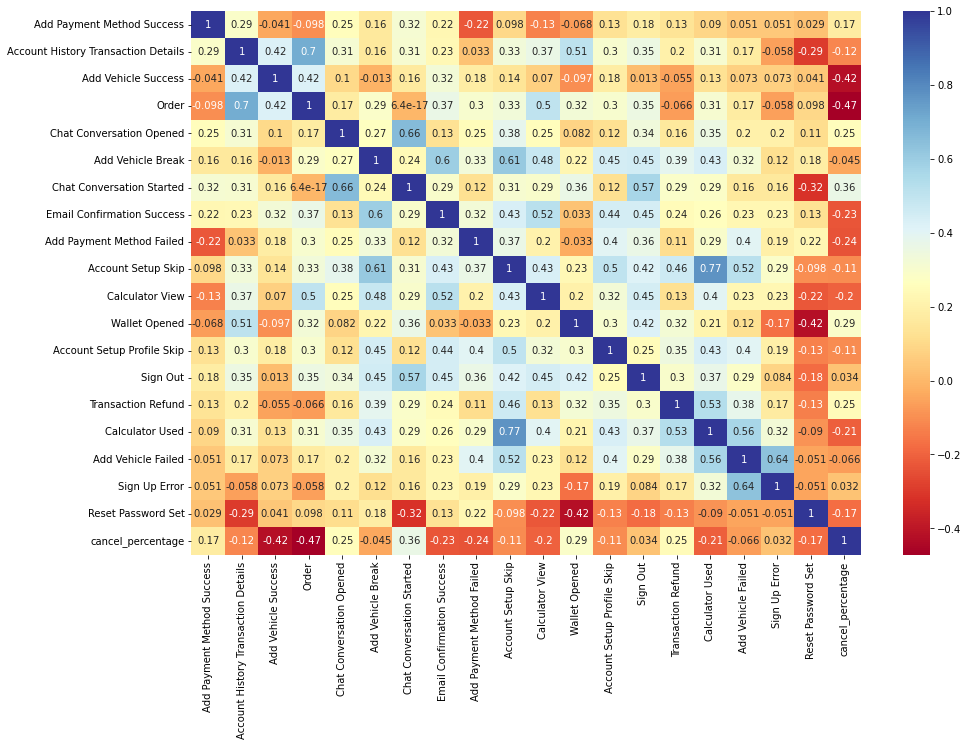

In [563]:
#df_feature_per_state
fig, ax = plt.subplots(figsize=(15,10))    
dataplot = sns.heatmap(df_feature_per_state.corr(), cmap="RdYlBu", annot=True)
plt.show()

In [564]:
df_feature_per_state.corr()["cancel_percentage"]

Add Payment Method Success             0.173526
Account History Transaction Details   -0.115623
Add Vehicle Success                   -0.422327
Order                                 -0.470743
Chat Conversation Opened               0.254613
Add Vehicle Break                     -0.045242
Chat Conversation Started              0.363799
Email Confirmation Success            -0.230750
Add Payment Method Failed             -0.238653
Account Setup Skip                    -0.106902
Calculator View                       -0.201246
Wallet Opened                          0.290012
Account Setup Profile Skip            -0.108586
Sign Out                               0.033762
Transaction Refund                     0.247031
Calculator Used                       -0.209809
Add Vehicle Failed                    -0.066353
Sign Up Error                          0.032386
Reset Password Set                    -0.173526
cancel_percentage                      1.000000
Name: cancel_percentage, dtype: float64

In [565]:
#df_feature_by_state = df_feature_by_state.drop_duplicates(subset = ["user_state"])

In [566]:
def remove_excess_events(df, tv):
    target_values = tv
    event_list = df["event_name"].unique()
    for i in event_list:
        df_temp = df[df["event_name"]==i]
        if i in target_values:
            continue
        df = df.drop(df_temp.index)
    return df

In [568]:
tv = ['Add Vehicle Break', 'Add Vehicle Failed', 'Add Vehicle Success', 
                     "Add Payment Method Failed", "Add Payment Method Success"]
df_errors = copy.deepcopy(df)
df_errors = remove_excess_events(df_errors, tv)
count = df_errors.groupby(["userid", "event_name"])["event_name"].count().unstack(fill_value=0).stack()

In [569]:
target_values = ['Add Vehicle Break', 'Add Vehicle Failed', 'Add Vehicle Success', "Add Payment Method Failed", "Add Payment Method Success"]


In [570]:
targer_values_count = [[count[5*j + i] for j in range(int(len(count)/5))] for i in range(5)]

for i in range(int(len(count)/5)):
    if (count[5*i + 2] + count[5*i + 3] + count[5*i + 4]) == 0:
        count[5*i + 2] = 1
    if (count[5*i] + count[5*i + 1]) == 0:
        count[5*i] = 1
error_rate_vehicle = [float(count[5*i + 4])/(count[5*i + 2] + count[5*i + 3] + count[5*i + 4]) for i in range(int(len(count)/5))]
error_rate_payment = [float(count[5*i + 1])/(count[5*i] + count[5*i + 1]) for i in range(int(len(count)/5))]

In [571]:
#print(len(error_rate_vehicle))
#df_errors.drop_duplicates(subset = ["userid"])

In [572]:
df_errors = df_errors.drop_duplicates(subset = ["userid"])
df_errors = df_errors.drop(['event_name', 'event_attributes', 'event_created_date',
                                          "user_state", "event_platform","device_manufacture", "device_model"], axis=1)
df_errors["error_rate_vehicle"] = error_rate_vehicle
df_errors["error_rate_payment"] = error_rate_payment
for i in range(5):
    df_errors[target_values[i]] = targer_values_count[i]

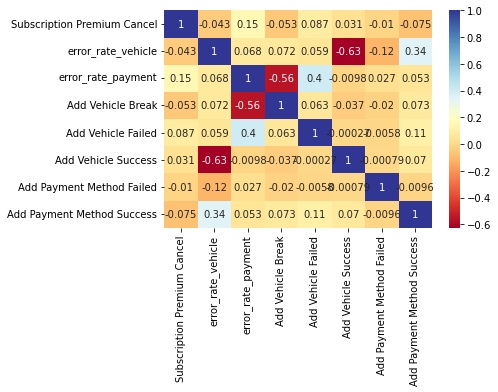

In [573]:
dataplot = sns.heatmap(df_errors.corr(), cmap="RdYlBu", annot=True)
plt.show()

In [574]:
df_errors.to_csv("csv//error_data.csv")

In [575]:
df_feature_per_state.to_csv("csv//feature_per_state.csv")

In [ ]:
df_feature_per_state2 = copy.deepcopy(df_feature_by_state)

In [508]:
df_feature_by_state.to_csv("csv//feature_by_state.csv")

In [ ]:
df_feature_per_state2['Events Encoding'] = df_feature_by_state2.apply(event_encoding, axis=1)

In [ ]:
['Add Vehicle Break', 'Transaction Refund']
df_refund = copy.deepcopy(df)
df_refund = remove_excess_events(df_refund)
df_refund = df_refund.drop(["user_state", "event_platform","device_manufacture", "device_model"], axis=1)

In [516]:
df["event_name"].unique()

array(['Add Payment Method Success', 'Subscription Premium',
       'Account History Transaction Details', 'Add Vehicle Success',
       'Subscription Premium Renew', 'Sign Up Success',
       'Account Setup Profile Skip', 'Calculator View', 'Order',
       'Sign Out', 'Chat Conversation Opened', 'Add Vehicle Break',
       'Chat Conversation Started', 'Wallet Opened',
       'Email Confirmation Success', 'Add Payment Method Failed',
       'Account Setup Skip', 'Calculator Used',
       'Subscription Premium Cancel', 'Sign Up Error',
       'Transaction Refund', 'Add Vehicle Failed', 'Reset Password Set'],
      dtype=object)

In [515]:

df[df["event_name"] == 'Transaction Refund']["event_attributes"].unique()

array(['{"Id":"85298a4db30c1fb4f302b117f0b2b0fc","Amount":"-20"}',
       '{"Id":"cbfa941e216de1d3f2bd8f26ace2037d","Amount":"-10"}',
       '{"Id":"ce785427f4b3c2a038bbc18e76cec6e1","Amount":"-10"}',
       '{"Id":"5ed652314b516e5cb96e72a484106ff9","Amount":"-9.99"}',
       '{"Id":"8a53f0da2d0e0f5f579a5c97c7cf478d","Amount":"-10"}',
       '{"Id":"3857f1c2e0c0df4b42c3d0cb7839908e","Amount":"-20"}',
       '{"Id":"ee4ea4dce7c24010bc02dcaf21739206","Amount":"-10"}',
       '{"Id":"8dfad62ef496f31295eaf6f14662fde9","Amount":"-20"}',
       '{"Id":"570f2db617899393f6fe057112a4b894","Amount":"-50"}',
       '{"Id":"6c2ad2e1f3333aad88f665453970ae98","Amount":"-10"}',
       '{"Id":"4fdfe77889d2727bca487b985e5258a2","Amount":"-24.29"}',
       '{"Id":"459fa7357a9138e2d9a78f2643711714","Amount":"-50"}',
       '{"Id":"abb700649f62a3d92ddcdf33e98862e1","Amount":"-10"}',
       '{"Id":"a06df3f8a4e3b4bb21ab0a01f186c3a7","Amount":"-20"}',
       '{"Id":"e12e7fca6bee6c15768229268fb37e5d","Amount"